## This notebook is built from the combined dataset that Lawrence has assembled and supplements Danny's EDA.

### Imports and Useful Constants

In [65]:
import pickle
from collections import Counter

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

filename = "../../datasets/acousticbrainz_all_flattened_labeled.pickle.bz2"

base_genres = [
    "genre_blues",
    "genre_classical",
    "genre_country",
    "genre_disco",
    "genre_hiphop",
    "genre_jazz",
    "genre_metal",
    "genre_pop",
    "genre_reggae",
    "genre_rock",
]

subgenres = [
    "genre_orchestral",
    "genre_poprock",
    "genre_instrumentalpop",
    "genre_rap",
    "genre_punkrock",
    "genre_symphonic",
    "genre_instrumentalrock",
    "genre_hardrock",
    "genre_grunge",
    "genre_rocknroll",
    "genre_acidjazz",
    "genre_heavymetal",
    "genre_classicrock",
    "genre_jazzfusion",
    "genre_alternativerock",
]

unidentified_genres = [
    "genre_alternative",
    "genre_dance",
    "genre_indie",
    "genre_folk",
    "genre_popfolk",
    "genre_triphop",
    "genre_funk",
    "genre_rnb",
    "genre_soul",
    "genre_ska",
    "genre_groove",
    "genre_jazzfunk",
    "genre_swing",
    "genre_bossanova",
    "genre_bluesrock",
]

# The genre_map_ranks dictionary provides the ranking genre mapping
# that we can use to disambiguate tracks with multiple base tags.
# Here, a lower number is a higher rank where the idea is to prefer
# lesser represented genres over more well represented genres in the
# data set.

genre_map_ranks = {
    "genre_disco": 1,
    "genre_country": 2,
    "genre_blues": 3,
    "genre_metal": 4,
    "genre_reggae": 5,
    "genre_jazz": 6,
    "genre_hiphop": 7,
    "genre_rock": 8,
    "genre_classical": 9,
    "genre_pop": 10,
}

### Useful Functions

In [2]:
def to_base_genre_label(index):
    """Return the base genre label for a dense genre index."""
    return base_genres[index]


def to_base_genre_index(label):
    """Return the dense genre index for a base genre label."""
    return base_genres.index(label)


def multi_genre_mapping_label(genre_ids, verbose=False):
    """Return the highest rank base genre label given a list of dense genre indices."""

    if verbose:
        print(
            f"Evaluating: {[to_base_genre_label(id) for id in genre_ids]} ==> ", end=""
        )

    rank_list = [genre_map_ranks[to_base_genre_label(id)] for id in genre_ids]
    best_rank = min(rank_list)
    for (key, val) in genre_map_ranks.items():
        if best_rank == val:
            if verbose:
                print(key)
            return key
    return None

### Load dataset and confirm shape

In [3]:
df = pd.read_pickle(filename)
df.shape

(55213, 2877)

### Remove features since we are only looking at labels in this notebook

In [4]:
df = df.filter(regex="^genre")
df.shape

(55213, 95)

In [5]:
df.columns

Index(['genre_60s', 'genre_70s', 'genre_80s', 'genre_90s', 'genre_acidjazz',
       'genre_african', 'genre_alternative', 'genre_alternativerock',
       'genre_ambient', 'genre_atmospheric', 'genre_blues', 'genre_bluesrock',
       'genre_bossanova', 'genre_breakbeat', 'genre_celtic', 'genre_chanson',
       'genre_chillout', 'genre_choir', 'genre_classical', 'genre_classicrock',
       'genre_club', 'genre_contemporary', 'genre_country', 'genre_dance',
       'genre_darkambient', 'genre_darkwave', 'genre_deephouse', 'genre_disco',
       'genre_downtempo', 'genre_drumnbass', 'genre_dub', 'genre_dubstep',
       'genre_easylistening', 'genre_edm', 'genre_electronic',
       'genre_electronica', 'genre_electropop', 'genre_ethnicrock',
       'genre_ethno', 'genre_eurodance', 'genre_experimental', 'genre_folk',
       'genre_funk', 'genre_fusion', 'genre_gothic', 'genre_groove',
       'genre_grunge', 'genre_hard', 'genre_hardrock', 'genre_heavymetal',
       'genre_hiphop', 'genre_hous

#### Partition the data into tracks tagged as being in one of the base genres and those that are not.

In [6]:
df_base = df[df[base_genres].sum(axis=1) > 0]
df_base_excluded = df[df[base_genres].sum(axis=1) == 0]

In [7]:
print(f"Tracks in base genre set: {df_base.shape[0]:,}")
print(f"Tracks not in base genre set: {df_base_excluded.shape[0]:,}")
print(f"Tracks in complete collection: {df.shape[0]:,}")

Tracks in base genre set: 25,562
Tracks not in base genre set: 29,651
Tracks in complete collection: 55,213


#### Replicating base class genre information from Danny's EDA

In [8]:
df[base_genres].sum(axis=0).sort_values(ascending=False)

genre_pop          7805
genre_rock         6865
genre_classical    5602
genre_hiphop       2657
genre_jazz         2371
genre_metal        1435
genre_reggae       1245
genre_blues        1082
genre_country       584
genre_disco         447
dtype: int64

Let's see how many tracks in this set are in more than one base genre.  In order to look at this, we only look at the columns in the data frame that correspond to base labels.

In [9]:
df_base[base_genres].shape

(25562, 10)

In [10]:
df_base[base_genres].sum(axis=1).value_counts()

1    21351
2     3910
3      283
4       17
5        1
dtype: int64

<AxesSubplot:>

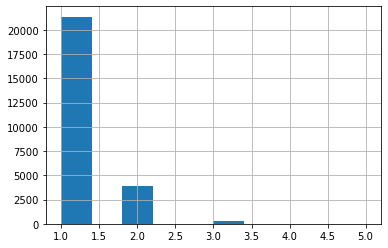

In [11]:
df_base[base_genres].sum(axis=1).hist()

#### Replicating identified subgenre information from Danny's EDA

Note that these tracks are those that are not already tagged as being in any of our base genres.  So, for example, if a track is tagged as `rock` and also `rocknroll` it is captured above and not reflected here.  On the other hand, if a track is tagged as `rocknroll` but not otherwise tagged as being in one of our base genres, it is reflected here.  So, any mapping we do with this set into the base groups will be effective to enlarge the base groups.

In [12]:
df[subgenres].sum(axis=0).sort_values(ascending=False)

genre_orchestral          2432
genre_poprock             2172
genre_instrumentalpop     1477
genre_rap                  993
genre_punkrock             729
genre_symphonic            712
genre_instrumentalrock     598
genre_hardrock             490
genre_grunge               375
genre_rocknroll            342
genre_acidjazz             304
genre_heavymetal           222
genre_classicrock          222
genre_jazzfusion           221
genre_alternativerock      215
dtype: int64

#### Continuing EDA after removing any tracks in either the base or identified subgenre collections

This analysis continues by looking at the set of tracks in the `unidentified_genres` set after removing from consideration any tracks in either the base set or identified subgenre set.

In [13]:
df_base_and_subgenres_excluded = df[df[base_genres + subgenres].sum(axis=1) == 0]

If we built this dataframe correctly, none of the tracks should have `base` or `identified_subgenres` tags.

In [14]:
temp = df_base_and_subgenres_excluded.sum(axis=0)
temp[temp == 0]

genre_acidjazz            0
genre_alternativerock     0
genre_blues               0
genre_classical           0
genre_classicrock         0
genre_country             0
genre_disco               0
genre_grunge              0
genre_hardrock            0
genre_heavymetal          0
genre_hiphop              0
genre_instrumentalpop     0
genre_instrumentalrock    0
genre_jazz                0
genre_jazzfusion          0
genre_metal               0
genre_orchestral          0
genre_pop                 0
genre_poprock             0
genre_punkrock            0
genre_rap                 0
genre_reggae              0
genre_rock                0
genre_rocknroll           0
genre_symphonic           0
dtype: int64

It looks like we have excluded tracks that are in the base or identified_subgenre groups from the set as we hoped.  Now lets focus on the distribution of unidentified_genre tracks in what remains.

In [15]:
df_base_and_subgenres_excluded[unidentified_genres].sum(axis=0)

genre_alternative    1767
genre_dance          2059
genre_indie           758
genre_folk           1120
genre_popfolk         691
genre_triphop         692
genre_funk            398
genre_rnb             154
genre_soul            139
genre_ska              58
genre_groove           84
genre_jazzfunk         68
genre_swing            40
genre_bossanova        54
genre_bluesrock         3
dtype: int64

In [16]:
df_base_and_subgenres_excluded[["genre_folk", "genre_electronic", "genre_edm"]].sum(
    axis=0
)

genre_folk           1120
genre_electronic    12977
genre_edm             243
dtype: int64

### Techniques for Working With Our One Hot Encoded Classes

Here are some simple techniques we can uses to convert from sparse to dense genre encodings and to get a label for a genre from a dense encoding.

The numpy argmax function can be used to identify the index in a cluster of one hot encoded columns where the 1 value appears.  If two columns have a 1 in them the function will return the first such column index.  We will likely want to avoid this with data preprocessing.

Here are the dense encodings for the first fifteen tracks in base genres.  I'm not sure how to do this directly in pandas so I convert the data frame to a numpy array first.

In [17]:
some_dense_encodings = np.argmax(df_base[base_genres].to_numpy(), axis=1)[:15]
display(some_dense_encodings)

array([1, 9, 1, 5, 9, 5, 1, 7, 8, 9, 7, 1, 1, 7, 5])

Here are the one hot encodings for the same first fifteen tracks.

In [18]:
df_base[base_genres][:15]

,genre_blues,genre_classical,genre_country,genre_disco,genre_hiphop,genre_jazz,genre_metal,genre_pop,genre_reggae,genre_rock
2,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1
11,0,0,0,0,0,1,0,0,0,0
12,0,1,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,1,0,0
16,0,0,0,0,0,0,0,0,1,0
19,0,0,0,0,0,0,0,0,0,1


Map from a list of base genre indexes to the label strings using the to_base_genre_label helper function defined above.

In [19]:
[*map(to_base_genre_label, some_dense_encodings)]

['genre_classical',
 'genre_rock',
 'genre_classical',
 'genre_jazz',
 'genre_rock',
 'genre_jazz',
 'genre_classical',
 'genre_pop',
 'genre_reggae',
 'genre_rock',
 'genre_pop',
 'genre_classical',
 'genre_classical',
 'genre_pop',
 'genre_jazz']

### Tracks Tagged In More Than One Base Genre

Lets take a closer look at the 4,211 tracks that are tagged to more than one base genre using a mask to identify tracks with more than one of our base genre fields set to 1.

In [20]:
mask = df_base[base_genres].sum(axis=1) > 1
multiple_base_tracks = df_base[mask][base_genres]
display(multiple_base_tracks[0:5])
display(multiple_base_tracks.shape)

,genre_blues,genre_classical,genre_country,genre_disco,genre_hiphop,genre_jazz,genre_metal,genre_pop,genre_reggae,genre_rock
20,0,0,0,0,0,0,0,1,0,1
39,0,0,0,0,0,0,1,0,0,1
42,1,0,0,0,0,0,0,0,0,1
43,0,0,0,0,0,0,0,1,0,1
56,0,1,0,0,0,0,0,1,0,1


(4211, 10)

We use np.nonzero to identify indexes with nonzero genre column values in each row.  We convert the numpy arrays that nonzero returns to tuples so we can drop the tuples into a Counter object (something we can't do with arrays since arrays are not hashable).

It turns out that there are 78 unique groupings that appear in our dataset.

In [21]:
multiple_base_genres = [tuple(row.nonzero()[0]) for row in multiple_base_tracks.values]
multiple_base_genres[0:5]

[(7, 9), (6, 9), (0, 9), (7, 9), (1, 7, 9)]

In [22]:
counts = Counter(multiple_base_genres)

In [23]:
len(counts)

78

In [24]:
for count in counts.most_common():
    print(f"{count[1]:>4} {[*map(to_base_genre_label, count[0])]}")

1667 ['genre_pop', 'genre_rock']
 503 ['genre_metal', 'genre_rock']
 239 ['genre_hiphop', 'genre_jazz']
 207 ['genre_blues', 'genre_rock']
 148 ['genre_hiphop', 'genre_pop']
 141 ['genre_jazz', 'genre_pop']
 123 ['genre_classical', 'genre_jazz']
 101 ['genre_blues', 'genre_jazz']
  80 ['genre_classical', 'genre_pop']
  76 ['genre_blues', 'genre_pop']
  72 ['genre_reggae', 'genre_rock']
  71 ['genre_hiphop', 'genre_reggae']
  65 ['genre_disco', 'genre_pop']
  63 ['genre_blues', 'genre_pop', 'genre_rock']
  59 ['genre_jazz', 'genre_rock']
  50 ['genre_country', 'genre_rock']
  43 ['genre_country', 'genre_pop']
  39 ['genre_pop', 'genre_reggae']
  34 ['genre_classical', 'genre_metal']
  33 ['genre_pop', 'genre_reggae', 'genre_rock']
  29 ['genre_classical', 'genre_rock']
  29 ['genre_blues', 'genre_country']
  28 ['genre_hiphop', 'genre_rock']
  27 ['genre_jazz', 'genre_reggae']
  22 ['genre_jazz', 'genre_pop', 'genre_rock']
  21 ['genre_blues', 'genre_jazz', 'genre_rock']
  15 ['genre_bl

#### The `multi_genre_mapping_label` function.

One strategy for handling tracks tagged to multiple base genres is to prefer the least represented genre in the set of genres for which a track is associated.  The `multi_genre_mapping_label` function relies on the `genre_map_ranks` dictionary to implement that strategy.  The function returns the preferred genre label for a set of dense genre labels.  

The following cell shows the operation of that function on each unique collection in the dataset.

In [25]:
for tags in set(multiple_base_genres):
    multi_genre_mapping_label(tags, verbose=True)

Evaluating: ['genre_hiphop', 'genre_rock'] ==> genre_hiphop
Evaluating: ['genre_classical', 'genre_jazz', 'genre_pop'] ==> genre_jazz
Evaluating: ['genre_blues', 'genre_jazz', 'genre_pop', 'genre_rock'] ==> genre_blues
Evaluating: ['genre_reggae', 'genre_rock'] ==> genre_reggae
Evaluating: ['genre_blues', 'genre_jazz'] ==> genre_blues
Evaluating: ['genre_disco', 'genre_pop', 'genre_reggae'] ==> genre_disco
Evaluating: ['genre_blues', 'genre_pop'] ==> genre_blues
Evaluating: ['genre_hiphop', 'genre_metal', 'genre_rock'] ==> genre_metal
Evaluating: ['genre_hiphop', 'genre_pop', 'genre_reggae'] ==> genre_reggae
Evaluating: ['genre_hiphop', 'genre_reggae', 'genre_rock'] ==> genre_reggae
Evaluating: ['genre_blues', 'genre_rock'] ==> genre_blues
Evaluating: ['genre_blues', 'genre_country', 'genre_jazz', 'genre_rock'] ==> genre_country
Evaluating: ['genre_blues', 'genre_country', 'genre_reggae'] ==> genre_country
Evaluating: ['genre_jazz', 'genre_pop'] ==> genre_jazz
Evaluating: ['genre_blues

#### What does the base dataset look like if we eliminate tracks tagged to multiple genres?

In [26]:
mask = df_base[base_genres].sum(axis=1) == 1
df_base[mask][base_genres].shape

(21351, 10)

In [27]:
display(
    pd.merge(
        df_base[base_genres]
        .sum(axis=0)
        .sort_values(ascending=False)
        .rename("w/tracks in multiple classes"),
        df_base[mask][base_genres]
        .sum(axis=0)
        .sort_values(ascending=False)
        .rename("w/o tracks in multiple classes"),
        right_index=True,
        left_index=True,
    )
)

,w/tracks in multiple classes,w/o tracks in multiple classes
genre_pop,7805,5343
genre_rock,6865,4000
genre_classical,5602,5276
genre_hiphop,2657,2126
genre_jazz,2371,1552
genre_metal,1435,831
genre_reggae,1245,985
genre_blues,1082,468
genre_country,584,409
genre_disco,447,361


#### Assume dataset limited to base genre tracks tagged to a single genre
Create a single column data frame with labels

In [46]:
pro_forma_Y = df_base[mask][base_genres].copy()

In [47]:
pro_forma_Y

,genre_blues,genre_classical,genre_country,genre_disco,genre_hiphop,genre_jazz,genre_metal,genre_pop,genre_reggae,genre_rock
2,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
55203,0,0,1,0,0,0,0,0,0,0
55206,0,1,0,0,0,0,0,0,0,0
55208,0,1,0,0,0,0,0,0,0,0
55209,0,0,0,0,0,0,0,1,0,0


In [64]:
pro_forma_Y = df_base[mask][base_genres].copy()
dense_labels = np.argmax(pro_forma_Y.values, axis=1)
labels = [to_base_genre_label(dense_label) for dense_label in dense_labels]
pro_forma_Y.insert(0, "label", labels, allow_duplicates=True)
pro_forma_Y.drop(base_genres, inplace=True, axis=1)
pro_forma_Y

,label
2,genre_classical
3,genre_rock
4,genre_classical
5,genre_jazz
6,genre_rock
...,...
55203,genre_country
55206,genre_classical
55208,genre_classical
55209,genre_pop


In [63]:
display(pro_forma_Y)

,label
2,genre_classical
3,genre_rock
4,genre_classical
5,genre_jazz
6,genre_rock
...,...
55203,genre_country
55206,genre_classical
55208,genre_classical
55209,genre_pop


#### Use sklearn.preprocessing OneHotEncoder

In [79]:
encoder=OneHotEncoder()

In [80]:
encoder.fit(pro_forma_Y)

OneHotEncoder()

In [81]:
encoder.categories_

[array(['genre_blues', 'genre_classical', 'genre_country', 'genre_disco',
        'genre_hiphop', 'genre_jazz', 'genre_metal', 'genre_pop',
        'genre_reggae', 'genre_rock'], dtype=object)]

In [82]:
encoded_labels = encoder.transform(pro_forma_Y)

In [83]:
print(encoded_labels)

  (0, 1)	1.0
  (1, 9)	1.0
  (2, 1)	1.0
  (3, 5)	1.0
  (4, 9)	1.0
  (5, 5)	1.0
  (6, 1)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0
  (10, 1)	1.0
  (11, 1)	1.0
  (12, 7)	1.0
  (13, 5)	1.0
  (14, 1)	1.0
  (15, 5)	1.0
  (16, 1)	1.0
  (17, 9)	1.0
  (18, 7)	1.0
  (19, 7)	1.0
  (20, 8)	1.0
  (21, 1)	1.0
  (22, 5)	1.0
  (23, 7)	1.0
  (24, 9)	1.0
  :	:
  (21326, 1)	1.0
  (21327, 4)	1.0
  (21328, 9)	1.0
  (21329, 9)	1.0
  (21330, 7)	1.0
  (21331, 4)	1.0
  (21332, 9)	1.0
  (21333, 4)	1.0
  (21334, 1)	1.0
  (21335, 5)	1.0
  (21336, 9)	1.0
  (21337, 1)	1.0
  (21338, 4)	1.0
  (21339, 3)	1.0
  (21340, 1)	1.0
  (21341, 6)	1.0
  (21342, 1)	1.0
  (21343, 7)	1.0
  (21344, 1)	1.0
  (21345, 1)	1.0
  (21346, 2)	1.0
  (21347, 1)	1.0
  (21348, 1)	1.0
  (21349, 7)	1.0
  (21350, 7)	1.0
